<a href="https://colab.research.google.com/github/GHANTA-SRI-KSHONI/Appoitment-System/blob/main/STock_Market_Exchange.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM


In [2]:
# Download last 5 years of stock data (Apple example)
df = yf.download('AAPL', start='2018-01-01', end='2023-12-31')

# Show sample data
df.head()


/tmp/ipython-input-2-2187058385.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2018-01-01', end='2023-12-31')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.426834,40.436224,39.722779,39.933998,102223600
2018-01-03,40.419781,40.964251,40.356418,40.490187,118071600
2018-01-04,40.607529,40.710791,40.384579,40.492532,89738400
2018-01-05,41.069859,41.156691,40.612224,40.703751,94640000
2018-01-08,40.917328,41.213030,40.818757,40.917328,82271200


In [9]:
data = df[['Close']]
dataset = data.values

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)


In [11]:
training_data_len = int(np.ceil(len(dataset) * .8))

train_data = scaled_data[0:int(training_data_len), :]
# Create the training data set
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [12]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1148/1148 ━━━━━━━━━━━━━━━━━━━━ 36s 25ms/step - loss: 0.0071


In [13]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [14]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


/tmp/ipython-input-15-1407782068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


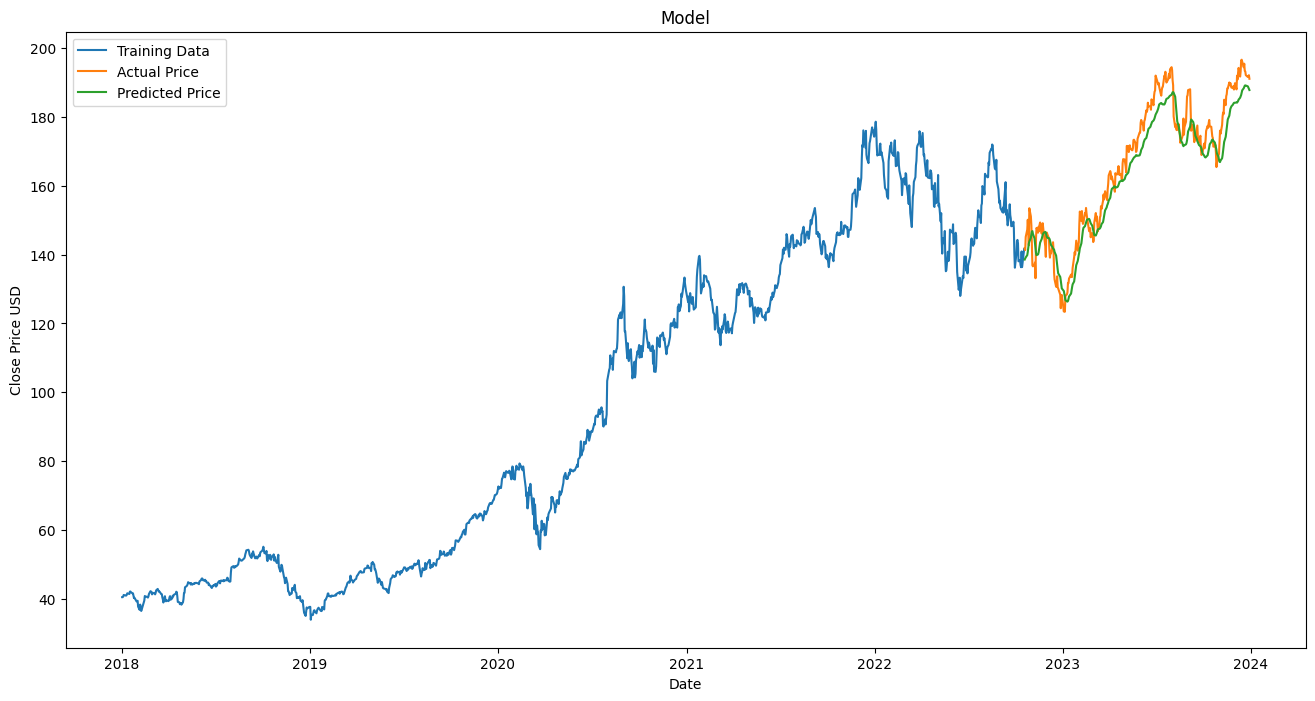

In [15]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train['Close'], label='Training Data')
plt.plot(valid[['Close']], label='Actual Price')
plt.plot(valid[['Predictions']], label='Predicted Price')
plt.legend()
plt.show()


In [16]:
# Get the last 60 days closing price
last_60_days = data[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)
pred_price = scaler.inverse_transform(pred_price)
print("Next day predicted price:", pred_price[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Next day predicted price: 187.49522


In [18]:
model.save('my_model.keras')
